1. Data Cleaning  
    1.1 Gain basic CSV overview  
    1.2 Formatiing NaN values    
    1.3 Transforming Coordinates  
    1.4 Transforming Timestamps  
    1.5 Checking for duplicates  
  
2. Data Overview  
    2.1 Gain Overview of data  
    2.2 Plot lines




1.1 Gain basic CSV overview

In [1]:
# import basic libs
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import shapely

In [2]:
# import csv as pd
data = pd.read_csv("data/atlantic.csv")

In [3]:
""" Plotting column an row aounts & header"""
print("Pandas Dataframe Info:\n")
data.info()
print("\n\nPandas DataFrame Head:\n")
data.head()

Pandas Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


We see that 22 columns are available, containing 49104 rows with hurrican data points.  
For now, the following info is important:  
- Unique IDs
- Hurricanes ordered by 'string' names
- Date and time are in separate rows -> maybe they should be converted to datetime format
- coordinates are objects, likely shapely -> Since the bearing will be calculated manualy, the coordinates shall be converted to numbers
- the int value -999 is most likely the NaN value -> Conversion to proper numpy.nan

# 1.2 Formating NaN values  
Using the pd.replace() method, all numerical -999 values are replaced with the proper numpy NaN data type

In [4]:
"""convert -999 & -99 to NaN"""
data = data.replace(-999,np.NaN)
data = data.replace(-99,np.NaN)

# 1.3 Transforming Coordinates  
By iterating over the latitude and longitude strings, the last index is checked. The string is then transformed into floats and based on the heading turned negative or not.

In [5]:
"""convert string coordiantes no numerical"""
# empty list to append to
lat_transformed = []
# iterate over dataframe lat
for i in data["Latitude"]:
    # initiate and clear variable to hold string first then converted float
    # tmp_val = 0
    # check if N at end
    if i[-1]=="N":
        # assign temp value, exclude last index (N), convert to float
        tmp_val = float(i[:-1])
    #check if S at the end
    if i[-1]=="S":
        # assign temp value, exclude last index (N), convert to float
        # substract double the amount to get same value in negative
        tmp_val =  float(i[:-1]) - (float(i[:-1])*2)
    # append temp value to lat list
    lat_transformed.append(tmp_val)

#empty list to append to
lon_transformed = []
# iterate over dataframe lon
for i in data["Longitude"]:
    # check if E at end
    if i[-1]=="E":
        # assign temp value, exclude last index (N), convert to float
        tmp_val = float(i[:-1])
    # check if W at the end
    if i[-1]=="W":
        # assign temp value, exclude last index (N), convert to float
        # substract double the amount to get same value in negative
        tmp_val =  float(i[:-1]) - (float(i[:-1])*2)
    # append temp value to lon list
    lon_transformed.append(tmp_val)

# update lat and lon columns with the transformed info
data["Latitude"] = lat_transformed
data["Longitude"] = lon_transformed
del i, lat_transformed,lon_transformed,tmp_val

# 1.4 Transforming Timestamps  
Since the time and date are in different columns and not the proper data types, the two columns are iterated over and concatenated. using the datetime library, the resulting string is then turned into the datetime datatype. For that to happen, the information is unified by adding leading zeros to the hour&minute information, so that the format information can be passed to the strptime() function.

In [6]:
"""transform date & time columns to datetime format"""
import datetime as dt
# empty list that holds tiemstamps
timestamps = []
# iterate over date and time
for date,time in zip(data["Date"],data["Time"]):
    # adding leading zeroes to time until length = 4
    while len(str(time)) < 4:
        time = str(0)+str(time)
    # concatenating date and time separated by space, appending 00 for the seconds
    timestamp = str(date) + " " + str(time) + "00"
    # transform string via strptime, passing format info
    timestamps.append(dt.datetime.strptime(timestamp, "%Y%m%d %H%M%S"))
# append dataframe with timestamps list
data["Timestamp"] = timestamps
data.drop(["Date","Time"], axis = 1, inplace = True)
del date,time,timestamp

# 1.5 Checking for Duplicates

Since there are no unique datapoint identifiers, the only way duplicates cam be detected is by seeing if a certain combination of attributes occurs in more than one row. For that, it is checked if/how many duplicates the pd.duplicated() function finds.

In [7]:
counter_false = 0
counter_true = 0
for i in data.duplicated():
    if i == True:
        counter_true = counter_true + 1
    else:
        counter_false = counter_false + 1
print("No. of duplicates in DF:\t"+str(counter_true))
print("No. of unique rows in DF:\t"+str(counter_false))
del counter_false,counter_true,i

No. of duplicates in DF:	0
No. of unique rows in DF:	49105


In [8]:
data.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Timestamp
0,AL011851,UNNAMED,,HU,28.0,-94.8,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0,-95.4,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0,-96.0,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1851-06-25 12:00:00
3,AL011851,UNNAMED,,HU,28.1,-96.5,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1851-06-25 18:00:00
4,AL011851,UNNAMED,L,HU,28.2,-96.8,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1851-06-25 21:00:00


# 2.1 Gain overview over data  
Now that some basic data cleaning and preparation was done, lets have a look at the data itself. The values that the columns exhibit are checked first.

In [9]:
"""uniqie values in IDs, Status"""
print("Unique IDs, therefore total number of Hurricanes: ",len(data.ID.unique()))
print("Average no. of data points per Hurricane: " + str(round( len(data)/len(data.ID.unique() ),2)))

status = []
for i in data.Status.unique():
    status.append(i)
print("\nunique 'Status' column values: "+str(status))

event = []
for i in data.Event.unique():
    event.append(i)
print("unique 'Event' column values: "+str(event))
del status,event,i

Unique IDs, therefore total number of Hurricanes:  1814
Average no. of data points per Hurricane: 27.07

unique 'Status' column values: [' HU', ' TS', ' EX', ' TD', ' LO', ' DB', ' SD', ' SS', ' WV']
unique 'Event' column values: ['  ', ' L', ' R', ' I', ' P', ' W', ' C', ' S', ' G', ' T']


Next up, lets check the range of the Latitude and Longitude values by plotting them against each other.  
Note that this is not a geographical plot yet since no projection is taken into account, rather only a way of finding clusters and outliers.

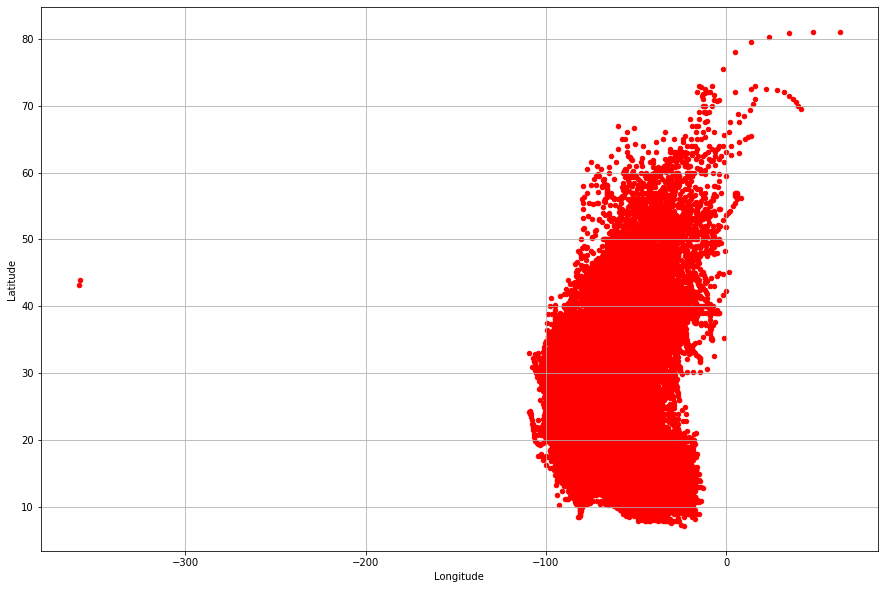

In [10]:
data.plot("Longitude","Latitude",kind="scatter",grid=True,color="red",figsize=(15,10))

Usually, statistical methods such as the standard deviation could be used to eleminate outliers. but in a case this clear, where a nice clustering is present and only a few outliers have Longitude values of under -300, we can manually eliminate them based on a threshold. For the outliers on the top right near the cluser, they are in a nice formation so that it seems logical that there was an exeptionally north and west storm on year, so no efforts to sliminate further storms will be made.  

Now, let's gain some statistical understanding of the numerical values.

In [11]:
data.describe()

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,48767.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,27.044904,-65.682533,53.051695,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,10.077880,19.687240,24.747884,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,7.200000,-359.100000,10.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.400000,-68.000000,50.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


Since the wind directions are separated in different columns and then set to zero if the wind doesnt come from that certain direction, the wind speed data points have mostly zero values. The zero values are therefore changed to NaN aswell

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49102.000000,48767.000000,18436.000000,3837.000000,3674.000000,2861.000000,3298.000000,2159.000000,1994.000000,1660.000000,1826.000000,1190.000000,1154.000000,992.000000,1031.000000
mean,27.044904,-65.686546,53.051695,992.244250,126.329163,123.316549,100.678085,106.205276,67.579898,68.385155,55.027108,59.674151,40.352941,37.751300,30.625000,36.003880
std,10.077880,19.681145,24.747884,19.113748,79.744560,81.149871,80.425082,76.193733,42.925243,46.271414,38.701215,40.043340,25.459639,25.551839,19.872512,23.778631
min,7.200000,-359.100000,10.000000,882.000000,10.000000,10.000000,10.000000,10.000000,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,5.000000,10.000000
25%,19.100000,-81.000000,35.000000,984.000000,70.000000,60.000000,45.000000,50.000000,40.000000,30.000000,30.000000,30.000000,20.000000,20.000000,15.000000,20.000000
50%,26.400000,-68.000000,50.000000,999.000000,105.000000,100.000000,75.000000,90.000000,60.000000,60.000000,45.000000,50.000000,30.000000,30.000000,25.000000,30.000000
75%,33.100000,-52.500000,70.000000,1006.000000,160.000000,150.000000,120.000000,140.000000,90.000000,90.000000,70.000000,75.000000,50.000000,50.000000,40.000000,50.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


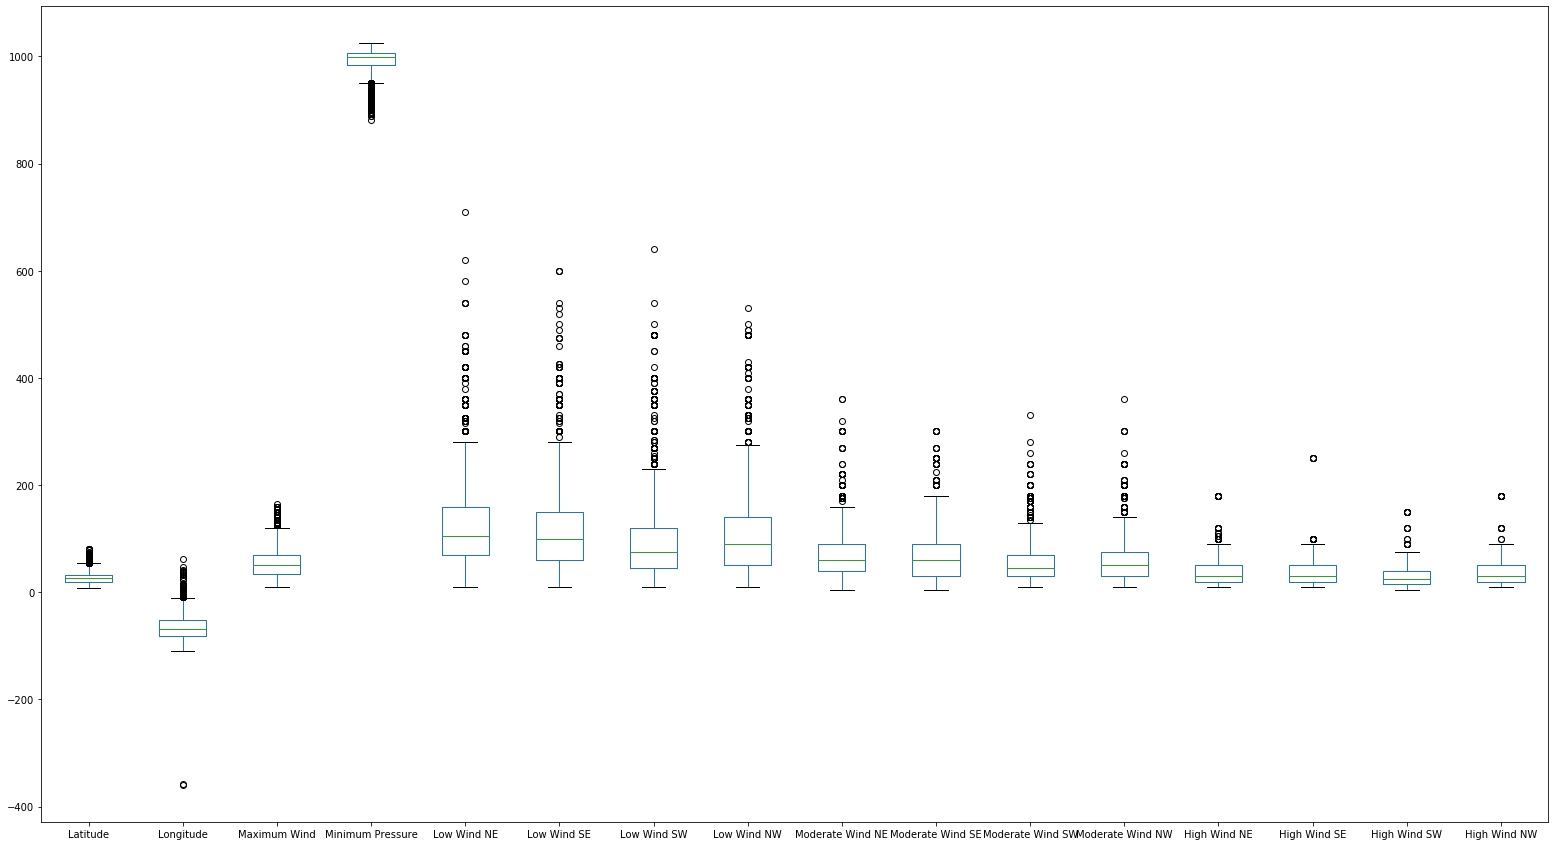

In [12]:
data = data.replace(0,np.NaN)
data.plot(kind="box",figsize=(27,15))
data.describe()

As usual, the boxes of the boxplot extend from Q1 to Q3 with the median line in the middle. Here, the whiskers extend up to the farthest data point within interquartal range ( 1,5*(Q3-Q1) ), the individual data points plotted as dots are considered outliers in this example.  
As seen before, the Longitude outliers are quite prominent here. Especially for the low wind data directional data points, quite a few outliers are detected, but some aswell for the high wind directional data points. 